<a href="https://colab.research.google.com/github/souzaneh/git_project_/blob/main/Trade_App_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import liberary  // data _prepration

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM, GRU

In [2]:
!pip install yfinance

In [3]:
import yfinance as yf

In [6]:

import datetime
# Set the end date to the current date
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
ms = yf.download('GOOGL', start='2010-01-01', end=end_date, progress=False)
df = ms [['Open','Close', 'High', 'Low']].round(3)
df.head(3)

Price,Open,Close,High,Low
Ticker,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,
2010-01-04,15.633,15.628,15.697,15.565
2010-01-05,15.639,15.559,15.655,15.498
2010-01-06,15.606,15.167,15.606,15.119


In [7]:
 x_step = 10
 y_step = 2
train_ratio =0.8

In [8]:
# prepration data(train/validation splite, return sequences)

def sequence_data (df, x_step, y_step,train_ratio):

#train/val split:
  h = int(train_ratio*len(df))
  train = df[: h]
  val = df [h-(x_step+y_step):]

  train_C = train.Close.values
  val_C = val.Close.values
  print ('train_C.shape:',train_C.shape)

  sc = MinMaxScaler(feature_range=(0,1))
  train_C_s = sc.fit_transform(train_C)


  #train sequences
  x_seq = []
  y_seq = []
  for i in range(x_step, len(train_C)-y_step+1):
    x_seq.append(train_C_s[i-x_step:i,0]) # 0: make (n,1) to (n,) shape, convert from culomn/vertically display to row/horizontally display
    y_seq .append (train_C_s[i:i+y_step,0])

  x_train= np.array(x_seq)
  x_train = x_train .reshape(x_train.shape[0],x_train.shape[1],1)
  y_train= np.array(y_seq)

  #val sequences
  val_C_s = sc.transform(val_C)
  x_seq = []
  y_seq = []
  for i in range(x_step, len(val_C)-y_step+1):
    x_seq.append(val_C_s[i-x_step:i,0])
    y_seq .append (val_C_s[i:i+y_step,0])

  x_val= np.array(x_seq)
  x_val = x_val .reshape(x_val.shape[0],x_val.shape[1],1)
  y_val= np.array(y_seq)


  return x_train, y_train, x_val, y_val,sc,  train_C,val_C,

In [9]:
# prepration data(train/validation splite, return sequences)
x_train,  y_train , x_val, y_val, sc,train_C_df,val_C_df = sequence_data(df, x_step, y_step,train_ratio)

train_C.shape: (3046, 1)


In [10]:
# shapes :
df.shape,x_train.shape,y_train.shape,x_val.shape,y_val.shape,train_C_df.shape,val_C_df.shape

((3808, 4),
 (3035, 10, 1),
 (3035, 2),
 (763, 10, 1),
 (763, 2),
 (3046, 1),
 (774, 1))

In [11]:
df.Close.values[:3,0].shape

(3,)

#SimleRNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

simplernn_model = Sequential([
                                SimpleRNN(50, return_sequences = True),
                               # SimpleRNN(100, return_sequences = True),
                                SimpleRNN(50),
                                Dense(y_step)
                                ])

simplernn_model.compile(optimizer='Adam', loss= 'mae')

In [ ]:
simplernn_model.evaluate(x_val,y_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3845


0.42853420972824097

## SimleRNN_ keras_tuning

In [ ]:
!pip install keras_tuner --upgrade

In [ ]:
from keras_tuner import RandomSearch

In [ ]:
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 5)

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Only the last layer should not return sequences
        if i == 0:
            model.add(SimpleRNN(
                hp.Choice(f'units_{i}', [30, 50, 80, 100]),
                return_sequences=return_sequences,
                input_shape=(x_train.shape[1], x_train.shape[2])  # 3d input shape , we should set inut shape  as it is custom layer and model...
            ))
        else:
            model.add(SimpleRNN(
                hp.Choice(f'units_{i}', [25, 55, 85, 105]),
                return_sequences=return_sequences
            ))

    model.add(Dense(y_step))  # This should be 3 if y_train has a shape of (samples, 3)
    model.compile(optimizer='adam', loss='mae')

    return model

In [ ]:
tuner1 = RandomSearch( build_model, objective='val_loss',
                      max_trials=5,directory='my_dir', project_name='Simplernn_model_tuning5')

# Train the tuner
tuner1.search(x_train, y_train, epochs=10, validation_data = (x_val,y_val), verbose=1)

Trial 5 Complete [00h 00m 37s]
val_loss: 0.03419461101293564

Best val_loss So Far: 0.02456737495958805
Total elapsed time: 00h 02m 35s


In [ ]:
# Display all trial results
trials = tuner1.oracle.get_best_trials(num_trials=len(tuner1.oracle.trials))
print("Final Results:")
for trial in trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score (_MAE_ Validation Loss): {trial.score}")
    print("")

Final Results:
Trial ID: 3
Hyperparameters: {'num_layers': 1, 'units_0': 80, 'units_1': 25, 'units_2': 25, 'units_3': 105}
Score (_MAE_ Validation Loss): 0.02456737495958805

Trial ID: 0
Hyperparameters: {'num_layers': 3, 'units_0': 100, 'units_1': 25, 'units_2': 25}
Score (_MAE_ Validation Loss): 0.03114379569888115

Trial ID: 2
Hyperparameters: {'num_layers': 3, 'units_0': 50, 'units_1': 105, 'units_2': 55, 'units_3': 55}
Score (_MAE_ Validation Loss): 0.031403955072164536

Trial ID: 4
Hyperparameters: {'num_layers': 4, 'units_0': 100, 'units_1': 25, 'units_2': 25, 'units_3': 55}
Score (_MAE_ Validation Loss): 0.03419461101293564

Trial ID: 1
Hyperparameters: {'num_layers': 4, 'units_0': 30, 'units_1': 85, 'units_2': 25, 'units_3': 25}
Score (_MAE_ Validation Loss): 0.03516124188899994



In [ ]:
# Get the best model and its hyperparameters
simplernn_best_model = tuner1.get_best_models()[0]
best_hyperparameters = tuner1.get_best_hyperparameters()[0]

print("Number of hidden layers:", best_hyperparameters.get('num_layers'))
for i in range(best_hyperparameters.get('num_layers')):
    print(f"Units in layer {i+1}:", best_hyperparameters.get('units_' + str(i)))

Number of hidden layers: 1
Units in layer 1: 80


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# train simplernn_best_model more
simplernn_best_model.fit(x_train, y_train, epochs=100, validation_data = (x_val,y_val), verbose=1)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 0.0306
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0263
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0230
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0253
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0236
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060 - val_loss: 0.0275
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0216
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0216
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0059 - val_loss: 0.0275
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0059 - val_loss: 0.0199
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - val_loss: 0.0198
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

In [ ]:
simplernn_best_model.evaluate(x_val,y_val)
simplernn_y_val_pred = sc.inverse_transform(simplernn_best_model.predict(y_val))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# LSTM Model

In [ ]:
LSTM_model = Sequential([
                                LSTM(50, return_sequences = True),
                                LSTM(30),
                                Dense(y_step)
                                ])

LSTM_model.compile(optimizer='sgd', loss= "mean_squared_error")

LSTM_model.fit(x_train, y_train, epochs= 10, validation_data = (x_val,y_val))

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1648 - val_loss: 0.6045
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1337 - val_loss: 0.5330
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1187 - val_loss: 0.4458
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0853 - val_loss: 0.2825
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0441 - val_loss: 0.1318
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0187 - val_loss: 0.0768
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0178 - val_loss: 0.0691
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0170 - val_loss: 0.0886
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0176 - val_loss: 0.0748
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0163 - val_loss: 0.0754


In [ ]:
LSTM_model.evaluate(x_val,y_val), LSTM_model.evaluate(x_train,y_train)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0596
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128


(0.07537125051021576, 0.014779843389987946)

## LSTM TUNER

In [ ]:
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1,3)

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Only the last layer should not return sequences
        if i == 0:
            model.add(LSTM(
                hp.Choice(f'units_{i}', [20,30, 50, 60, 80]),
                return_sequences=return_sequences,
                input_shape=(x_train.shape[1], x_train.shape[2])  # 3d input shape , we should set inut shape  as it is custom layer and model...
            ))
        else:
            model.add(LSTM(
                hp.Choice(f'units_{i}', [15, 35, 65, 85]),
                return_sequences=return_sequences
            ))

    model.add(Dense(y_step))  # This should be 3 if y_train has a shape of (samples, 3)
    model.compile(optimizer='adam', loss='mae')

    return model

tuner = RandomSearch( build_model, objective='val_loss',
                      max_trials=5,directory='my_dir', project_name='LSTM_model_tuning2') #execution_per_trials =2,#direction='my_dir', #project_name='Suzi')

# Train the tuner
tuner.search(x_train, y_train, epochs=10, validation_data = (x_val,y_val), verbose=1)



Trial 5 Complete [00h 00m 15s]
val_loss: 0.024458512663841248

Best val_loss So Far: 0.024458512663841248
Total elapsed time: 00h 01m 51s


In [ ]:
# Get the best model and its hyperparameters
best_LSTM_model = tuner.get_best_models()[0]
best_LSTM_hyperparameters = tuner.get_best_hyperparameters()[0]

# Display all trial results
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))
print("Final Results:")
for trial in trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Score (_MAE_ Validation Loss): {trial.score}")
    print("")

# Get the best model and its hyperparameters
#LSTM_best_model = tuner.get_best_models()[0]
#best_hyperparameters = tuner.get_best_hyperparameters()[0]


print("Number of hidden layers _Best_Model:", best_hyperparameters.get('num_layers'))
for i in range(best_hyperparameters.get('num_layers')):
    print(f"Units in layer {i+1}:", best_hyperparameters.get('units_' + str(i)))

Final Results:
Trial ID: 4
Hyperparameters: {'num_layers': 1, 'units_0': 80, 'units_1': 15, 'units_2': 85}
Score (_MAE_ Validation Loss): 0.024458512663841248

Trial ID: 2
Hyperparameters: {'num_layers': 1, 'units_0': 50, 'units_1': 15, 'units_2': 15}
Score (_MAE_ Validation Loss): 0.02782624214887619

Trial ID: 0
Hyperparameters: {'num_layers': 2, 'units_0': 60, 'units_1': 15}
Score (_MAE_ Validation Loss): 0.02807968109846115

Trial ID: 3
Hyperparameters: {'num_layers': 3, 'units_0': 60, 'units_1': 85, 'units_2': 65}
Score (_MAE_ Validation Loss): 0.032567303627729416

Trial ID: 1
Hyperparameters: {'num_layers': 3, 'units_0': 20, 'units_1': 15, 'units_2': 15}
Score (_MAE_ Validation Loss): 0.032906174659729004

Number of hidden layers _Best_Model: 1
Units in layer 1: 80


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#train best_LSTM_model
best_LSTM_model.fit(x_train, y_train, epochs=100, validation_data = (x_val,y_val), verbose=1)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0197
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0217
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0193
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - val_loss: 0.0189
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0198
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 0.0183
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 0.0183
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0182
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0181
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0193
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

In [ ]:
best_LSTM_model.evaluate(x_val,y_val), best_LSTM_model.evaluate(x_train,y_train)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023


(0.017768267542123795, 0.004412169102579355)

In [ ]:
lstm_y_train_pred_b =  sc.inverse_transform(best_LSTM_model.predict(y_train))
lstm_y_val_pred_b =  sc.inverse_transform(best_LSTM_model.predict(y_val))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


#GRU Model

In [ ]:
GRU_model = Sequential([
                                GRU(50, return_sequences = True),
                                GRU(50),
                                Dense(y_step)
                                ])

GRU_model .compile(optimizer='Adam', loss= 'mae')

GRU_model .fit(x_train, y_train, epochs= 100, validation_data = (x_val,y_val))

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0848 - val_loss: 0.0240
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068 - val_loss: 0.0269
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - val_loss: 0.0221
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0218
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0062 - val_loss: 0.0206
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0060 - val_loss: 0.0204
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0058 - val_loss: 0.0202
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0061 - val_loss: 0.0206
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0060 - val_loss: 0.0187
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0190
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

In [ ]:
GRU_y_val_pred = sc.inverse_transform(GRU_model.predict(x_val) )

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


# LSTM_GRU Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM, GRU

LSTM_GRU_model = Sequential([
                                LSTM(50, return_sequences = True),
                                GRU(50),
                                Dense(y_step)
                                ])
LSTM_GRU_model.compile(optimizer='Adam', loss= 'mae')

LSTM_GRU_model.fit(x_train, y_train, epochs= 100, validation_data = (x_val,y_val))

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0907 - val_loss: 0.0334
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0339
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0303
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0311
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0310
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0272
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0321
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - val_loss: 0.0278
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0285
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - val_loss: 0.0258
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0078 - val_loss: 0.0360
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

In [13]:
lstm_GRU_y_val_pred = sc.inverse_transform(LSTM_GRU_model.predict(x_val) )

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


# Graph

In [ ]:
simplernn_y_val_pred[:3]

array([[146.92305, 144.10622],
       [146.80911, 143.98419],
       [143.93205, 141.06618]], dtype=float32)

In [ ]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-21',
               '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
               '2024-10-28', '2024-10-29'],
              dtype='datetime64[ns]', name='Date', length=3731, freq=None)

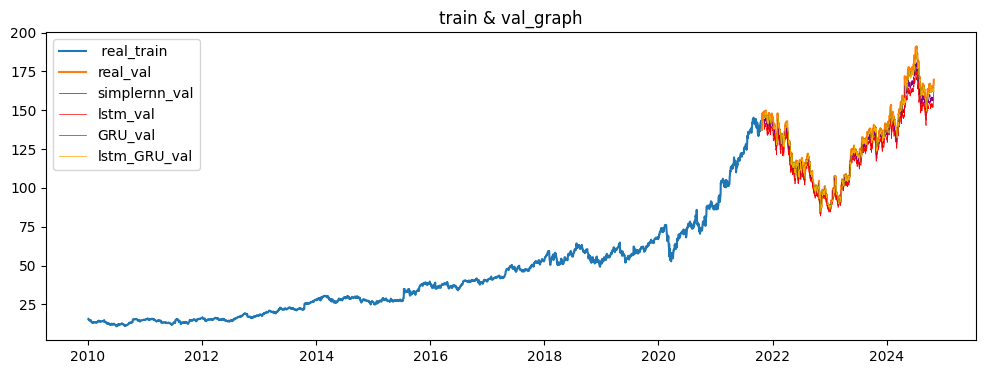

In [ ]:
fig , ax = plt.subplots(figsize=(12,4))
ax.plot(df.index[:len(train_C_df)],train_C_df, label =' real_train')
ax.plot(df.index[len(train_C_df)-(x_step + y_step):],val_C_df,label= 'real_val')
ax.plot(df.index[-len(simplernn_y_val_pred):],simplernn_y_val_pred[:,1],linewidth=0.5,label ='simplernn_val',color='purple')#1: choose 1 of columns
ax.plot(df.index[-len(lstm_y_val_pred_b):],lstm_y_val_pred_b[:,1],linewidth=0.5, label ='lstm_val',color='red')
#ax.plot(df.index[:len(lstm_y_train_pred_b)],lstm_y_train_pred_b[:,1],linewidth=0.5,label ='lstm_train') GRU_y_val_pred
ax.plot(df.index[-len(lstm_y_val_pred_b):],GRU_y_val_pred[:,1],linewidth=0.5, label ='GRU_val', color = 'green')
ax.plot(df.index[-len(lstm_y_val_pred_b):],lstm_GRU_y_val_pred[:,1],linewidth=0.5, label ='lstm_GRU_val',color='orange')
plt.title('train & val_graph')
ax.legend()

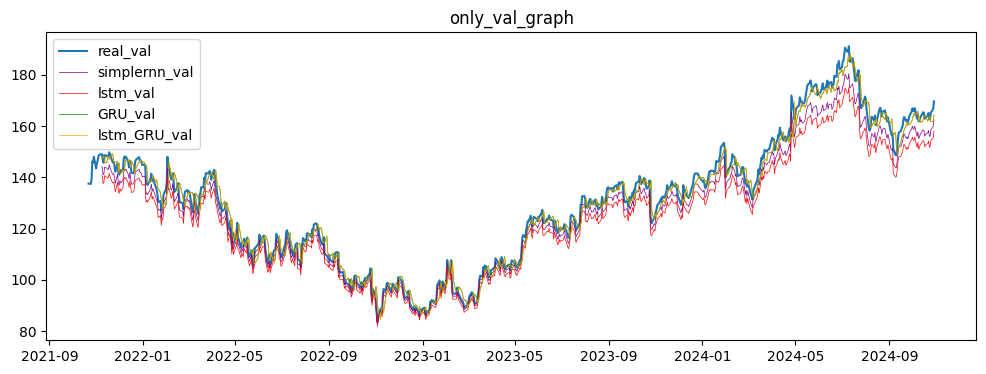

In [ ]:
# only val graph
fig , ax = plt.subplots(figsize=(12,4))
#ax.plot(df.index[:len(train_C_df)],train_C_df, label =' real_train')
ax.plot(df.index[len(train_C_df)-(x_step + y_step):],val_C_df,label= 'real_val',)
ax.plot(df.index[-len(simplernn_y_val_pred):],simplernn_y_val_pred[:,1],linewidth=0.5,label ='simplernn_val',color='purple')#1: choose 1 of columns
ax.plot(df.index[-len(lstm_y_val_pred_b):],lstm_y_val_pred_b[:,1],linewidth=0.5, label ='lstm_val',color='red')
#ax.plot(df.index[:len(lstm_y_train_pred_b)],lstm_y_train_pred_b[:,1],linewidth=0.5,label ='lstm_train') GRU_y_val_pred
ax.plot(df.index[-len(lstm_y_val_pred_b):],GRU_y_val_pred[:,1],linewidth=0.5, label ='GRU_val', color = 'green')
ax.plot(df.index[-len(lstm_y_val_pred_b):],lstm_GRU_y_val_pred[:,1],linewidth=0.5, label ='lstm_GRU_val',color='orange')
plt.title('only_val_graph')
ax.legend()


# Comparisom
## The LSTM_GRU  combination model has best prediction for validation data

In [ ]:
print(' For simplernn model, train & val evaluation is: ',simplernn_best_model.evaluate(x_train,y_train),simplernn_best_model.evaluate(x_val,y_val))
print('For lstm model train & val evaluation is: ',best_LSTM_model.evaluate(x_train,y_train),best_LSTM_model.evaluate(x_val,y_val))
print('For GRU model train & val evaluation is: ',GRU_model.evaluate(x_train,y_train),GRU_model.evaluate(x_val,y_val))
print('For  LSTM_GRU model train & val evaluation is: ',LSTM_GRU_model.evaluate(x_train,y_train),LSTM_GRU_model.evaluate(x_val,y_val))


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187
 For simplernn model, train & val evaluation is:  0.004968368448317051 0.01773836649954319
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191
For lstm model train & val evaluation is:  0.004412169102579355 0.017768267542123795
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174
For GRU model train & val evaluation is:  0.005339235067367554 0.01771504431962967
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171
For  LSTM_GRU model train & val evaluation is:  0.0043853833340108395 0.01703670434653759
